## DATA DOWNLOAD LINK

In [1]:
from urllib import request 
import os
import zipfile
data_name = ['CRC_DX_TRAIN_MSIMUT', 'CRC_DX_TRAIN_MSS', 'CRC_DX_TEST_MSS', 'CRC_DX_TEST_MSIMUT'] 
front_link = 'https://zenodo.org/record/2530835/files/' 
back_link = '.zip?download=1' 

# 폴더 디렉토리 생성 
os.makedirs('/content/TCGA_DATA') 
os.makedirs('/content/TCGA_DATA/CRC_TRAIN') 
os.makedirs('/content/TCGA_DATA/CRC_TEST')

for idx, data_type in enumerate(data_name):
  # 코랩 아니면 아래 경로 수정
  if idx <= 1:
    os.chdir('/content/TCGA_DATA/CRC_TRAIN')
  else:
    os.chdir('/content/TCGA_DATA/CRC_TEST')
  
  link = front_link + data_type + back_link
  request.urlretrieve(link,data_type) 
  zipfile.ZipFile(data_type).extractall()  
  print('One Done')



One Done
One Done
One Done
One Done


## DATA PATH 가져오기 

In [2]:
from glob import glob
DATA_PATH_TRAIN_LIST = glob('/content/TCGA_DATA/CRC_TRAIN/*/*.png') 
DATA_PATH_TEST_LIST = glob('/content/TCGA_DATA/CRC_TEST/*/*.png')

## Custom DataSet 

In [3]:
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform

class CRC_DataSet(Dataset):
    #data_path_list - 이미지 path 전체 리스트
    #label - 이미지 ground truth
    def __init__(self, data_path_list, classes, transform=None):
        self.path_list = data_path_list
        self.label = []
        for path in data_path_list:
            self.label.append(path.split('/')[-2])
        self.transform = transform
        self.classes = classes
    
    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = io.imread(self.path_list[idx])
        if self.transform is not None:
            image = self.transform(image)
        return image, self.classes.index(self.label[idx])

## Data Loader

In [4]:
import torch
from torchvision import transforms 

classes = ('MSIMUT', 'MSS')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainloader = torch.utils.data.DataLoader(
    CRC_DataSet(
        DATA_PATH_TRAIN_LIST, 
        classes,
        transform=transform
    ),
    batch_size=4,
    shuffle = True
)

testloader = torch.utils.data.DataLoader(
    CRC_DataSet(
        DATA_PATH_TEST_LIST, 
        classes,
        transform=transform
    ),
    batch_size=4,
    shuffle = False
)

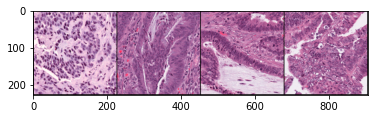

In [5]:
from matplotlib import pyplot as plt
import torchvision
import numpy as np
dataiter = iter(trainloader)
images, labels = dataiter.next() 
plt.imshow(torchvision.utils.make_grid(images, normalize= True).permute(1,2,0)) 
plt.show()

## Vit Model

In [8]:
!pip install git+https://github.com/FrancescoSaverioZuppichini/glasses
!pip install huggingface_hub
!pip install torchinfo
!pip install rich
!pip install einops

  Cloning https://github.com/FrancescoSaverioZuppichini/glasses to /tmp/pip-req-build-nrsk9xx_
  Running command git clone -q https://github.com/FrancescoSaverioZuppichini/glasses /tmp/pip-req-build-nrsk9xx_


In [9]:
# 출처 : https://github.com/FrancescoSaverioZuppichini/glasses 
from glasses.models import AutoModel, AutoTransform
model = AutoModel.from_pretrained('vit_large_patch16_224')
cfg = AutoTransform.from_name('vit_large_patch16_224')

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

## Visualization

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


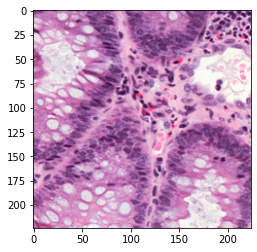

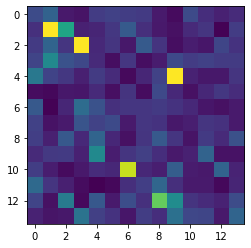

In [11]:
from glasses.interpretability import GradCam, SaliencyMap
from torchvision.transforms import Normalize
dataiter = iter(trainloader) 
images, labels = dataiter.next() 
plt.imshow(torchvision.utils.make_grid(images[0], normalize= True).permute(1,2,0)) 
_ = model.interpret(images[0].unsqueeze(0), using=SaliencyMap()).show()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


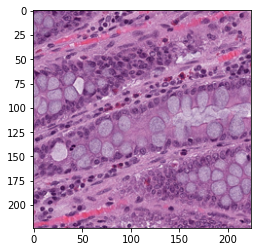

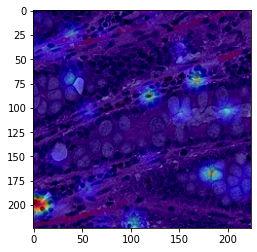

In [12]:
from glasses.interpretability import GradCam, SaliencyMap
from torchvision.transforms import Normalize
dataiter = iter(trainloader) 
images, labels = dataiter.next() 
plt.imshow(torchvision.utils.make_grid(images[0], normalize= True).permute(1,2,0)) 
_ = model.interpret(images[0].unsqueeze(0), using=GradCam()).show()

In [14]:
model.summary()

Layer (type:depth-idx)                                  Output Shape              Param #
ViT                                                     --                        --
├─TransformerEncoder: 1                                 --                        --
│    └─ModuleList: 2-1                                  --                        --
├─PatchEmbedding: 1-1                                   [1, 197, 1024]            --
│    └─Sequential: 2-2                                  [1, 196, 1024]            --
│    │    └─Conv2d: 3-1                                 [1, 1024, 14, 14]         787,456
│    │    └─Rearrange: 3-2                              [1, 196, 1024]            --
│    └─ViTTokens: 2-3                                   [1, 1, 1024]              1,024
├─TransformerEncoder: 1-2                               [1, 197, 1024]            --
│    └─ModuleList: 2-1                                  --                        --
│    │    └─TransformerEncoderBlock: 3-3            